# Data preparation section

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
installed_packages = [
    "opensmile",
    "google",
    "treelib",
    "graphviz",
]

for package in installed_packages:
    !pip install {package}

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd

In [3]:
import opensmile

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)


In [4]:
import glob

try:
    files = glob.glob("../data/raw/RAVDESS/*/*.wav")
except:
    from google.colab import drive
    drive.mount('/content/gdrive')
    files = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/IP/data/RAVDESS/*/*.wav")

In [5]:
file_name_to_emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

In [6]:
emotion_to_positivity_mapping = {
    "neutral": "positive",
    "calm": "positive",
    "happy": "positive",
    "sad": "negative",
    "angry": "negative",
    "fearful": "negative",
    "disgust": "negative",
    "surprised": "positive",
}

##### Data reading and normalisation

In [7]:
speech_data = smile.process_files(files)

In [8]:
normalised_speech_data=(speech_data-speech_data.mean())/speech_data.std()
normalised_speech_data.dropna(axis='columns', inplace=True)

In [9]:
emotion_labels = [file_name_to_emotion_mapping[file.split("-")[-5]] for file in files]

##### Splitting the data into training, validation and test sets

In [10]:
from sklearn.model_selection import train_test_split

speeches = normalised_speech_data
emotions = emotion_labels

speeches_train_and_val, speeches_test, emotions_train_and_val, emotions_test = train_test_split(speeches, emotions, test_size=0.2, random_state=42, stratify=emotions)
speeches_train, speeches_val, emotions_train, emotions_val = train_test_split(speeches_train_and_val, emotions_train_and_val, test_size=0.25, random_state=42, stratify=emotions_train_and_val)

In [11]:
emotions_binary_train = [emotion_to_positivity_mapping[emotion] for emotion in emotions_train]
emotions_binary_val = [emotion_to_positivity_mapping[emotion] for emotion in emotions_val]
emotions_binary_test = [emotion_to_positivity_mapping[emotion] for emotion in emotions_test]

In [12]:
# Pandas dataframes keep the old indexing after sampling, but I need it to be sequential, thus, a reset for the index
speeches_train.reset_index(drop=True, inplace=True)
speeches_val.reset_index(drop=True, inplace=True)
speeches_test.reset_index(drop=True, inplace=True)

In [13]:
from collections import Counter

print(f"{len(speeches_train)=}\t\t{len(emotions_train)=}")
print(f"{len(speeches_val)=}\t\t{len(emotions_val)=}")
print(f"{len(speeches_test)=}\t\t{len(emotions_test)=}")

print(f"{Counter(emotions_train)=}")
print(f"{Counter(emotions_val)=}")
print(f"{Counter(emotions_test)=}")

len(speeches_train)=864		len(emotions_train)=864
len(speeches_val)=288		len(emotions_val)=288
len(speeches_test)=288		len(emotions_test)=288
Counter(emotions_train)=Counter({'calm': 116, 'angry': 115, 'fearful': 115, 'sad': 115, 'happy': 115, 'surprised': 115, 'disgust': 115, 'neutral': 58})
Counter(emotions_val)=Counter({'sad': 39, 'disgust': 39, 'angry': 39, 'calm': 38, 'surprised': 38, 'fearful': 38, 'happy': 38, 'neutral': 19})
Counter(emotions_test)=Counter({'happy': 39, 'fearful': 39, 'surprised': 39, 'sad': 38, 'calm': 38, 'angry': 38, 'disgust': 38, 'neutral': 19})


# Classifier comparison section

##### Building classifiers

In [108]:
from locale import Error
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

def fit_predict_and_score_classifier(classifier, data_train, data_val, labels_train, labels_val, label_set):
    classifier.fit(data_train, labels_train)
    results = {"train": {}, "val": {}}
    
    for set_type in ["train", "val"]:
        if set_type == "train":
            data = data_train
            labels = labels_train
        elif set_type == "val":
            data = data_val
            labels = labels_val
        else:
            raise Error("Undefined data set type")

        labels_predicted = classifier.predict(data)

        results[set_type]["predictions"] = labels_predicted
        results[set_type]["accuracy"] = metrics.accuracy_score(labels, labels_predicted)
        results[set_type]["precision"] = metrics.precision_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["recall"] = metrics.recall_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["F1"] = metrics.f1_score(labels, labels_predicted, average="macro", zero_division=1)

    return results

def create_result_table(results):
    first_key = list(results.keys())[0]
    second_key = list(results[first_key].keys())[0]
    table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
    for classifier_name, classifier_data in results.items():
        for set_type, set_metrics in classifier_data.items():
              # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
            new_row = {"Classifier": classifier_name, "Set type": set_type} | set_metrics
            table = table.append(new_row, ignore_index=True)
    return table

# def create_result_table(results):
#     first_key = list(results.keys())[0]
#     second_key = list(results[first_key].keys())[0]
#     table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
#     for classifier_name, classifier_data in results.items():
#         for set_type, set_metrics in classifier_data.items():
#               # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
#             new_row = pd.DataFrame({"Classifier": classifier_name, "Set type": set_type} | set_metrics)
#             table = pd.concat([table, new_row], ignore_index=True)
#     return table

def calculate_f1_scores_by_class(labels_predicted, labels):
    all_labels = sorted(list(set(labels)))
    matrix_dimension = range(len(set(labels)))
    matrix = metrics.confusion_matrix(labels, labels_predicted, labels=all_labels)

    recalls = [matrix[index, index] / row_sum for index, row_sum in enumerate(np.sum(matrix, axis=1))]
    precisions = [matrix[index, index] / column_sum for index, column_sum in enumerate(np.sum(matrix, axis=0))]

    f1_scores = {label: {} for label in all_labels}
    for index, label in enumerate(all_labels):
        f1_scores[label] = 2 * (precisions[index] * recalls[index]) / (precisions[index] + recalls[index])

    return f1_scores

In [15]:
# These parameters are repeated, so they are unwrapped while calling functions to reduce clutter
multi_class_parameters = (speeches_train, speeches_val, emotions_train, emotions_val, set(emotions))
binary_parameters = (speeches_train, speeches_val, emotions_binary_train, emotions_binary_val, set(["positive", "negative"]))
initial_classifier_results = {}
initial_classifier_results_binary = {}

In [16]:
dummy_classifier_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_classifier_stratified = DummyClassifier(strategy="stratified")
logistic_regression = LogisticRegression(max_iter=1000)
svc_classifier = SVC()

##### Multi-class classification

In [17]:
initial_classifier_results["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *multi_class_parameters)

In [18]:
initial_classifier_results["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *multi_class_parameters)

In [19]:
initial_classifier_results["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *multi_class_parameters)

In [20]:
initial_classifier_results["svc"] = fit_predict_and_score_classifier(svc_classifier, *multi_class_parameters)

In [21]:
initial_classifier_results_table = create_result_table(initial_classifier_results)
display(initial_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_17532\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_17532\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_17532\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_17532\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=Tr

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[disgust, fearful, happy, neutral, disgust, su...",0.120370,0.118563,0.119340,0.118878
3,dummy_classifier_stratified,val,"[disgust, calm, neutral, calm, sad, surprised,...",0.128472,0.124919,0.127277,0.125359
4,logistic_regression,train,"[angry, fearful, neutral, sad, happy, surprise...",1.000000,1.000000,1.000000,1.000000
5,logistic_regression,val,"[calm, calm, surprised, sad, fearful, sad, neu...",0.680556,0.683352,0.677800,0.677776
6,svc,train,"[happy, fearful, neutral, sad, happy, surprise...",0.971065,0.968848,0.966436,0.967431
7,svc,val,"[sad, calm, surprised, sad, fearful, sad, neut...",0.604167,0.611779,0.586791,0.585068


In [22]:
f1_scores = calculate_f1_scores_by_class(initial_classifier_results["svc"]["val"]["predictions"], emotions_val)
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score}")

angry: 0.6
calm: 0.6799999999999999
disgust: 0.6301369863013699
fearful: 0.5970149253731344
happy: 0.5135135135135136
neutral: 0.41379310344827586
sad: 0.47500000000000003
surprised: 0.7710843373493975


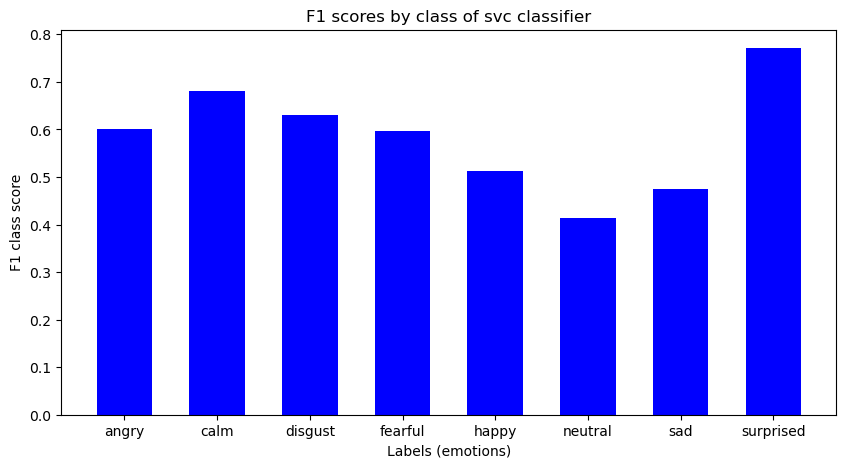

In [23]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions = list(f1_scores.keys())
f1_score_values = list(f1_scores.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions, f1_score_values, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of svc classifier")
plt.show()

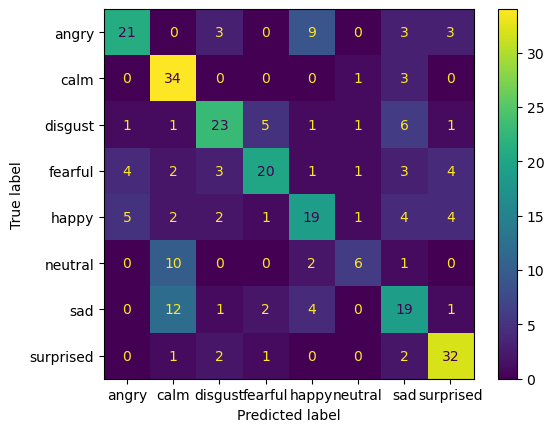

In [24]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(emotions_val, initial_classifier_results["svc"]["val"]["predictions"])
plt.show()

##### Binary classification

In [25]:
initial_classifier_results_binary["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *binary_parameters)

In [26]:
initial_classifier_results_binary["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *binary_parameters)

In [27]:
initial_classifier_results_binary["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *binary_parameters)

In [28]:
initial_classifier_results_binary["svc"] = fit_predict_and_score_classifier(svc_classifier, *binary_parameters)

In [29]:
initial_classifier_results_table_binary = create_result_table(initial_classifier_results_binary)
display(initial_classifier_results_table_binary)

C:\Users\Matas\AppData\Local\Temp\ipykernel_17532\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_17532\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_17532\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_17532\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=Tr

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[negative, negative, negative, negative, negat...",0.532407,0.766204,0.500000,0.347432
1,dummy_classifier_most_frequent,val,"[negative, negative, negative, negative, negat...",0.538194,0.769097,0.500000,0.349887
2,dummy_classifier_stratified,train,"[positive, negative, negative, negative, posit...",0.511574,0.509369,0.509363,0.509363
3,dummy_classifier_stratified,val,"[positive, negative, positive, positive, posit...",0.482639,0.483687,0.483604,0.482333
4,logistic_regression,train,"[negative, negative, positive, negative, posit...",1.000000,1.000000,1.000000,1.000000
5,logistic_regression,val,"[negative, positive, positive, negative, posit...",0.826389,0.826139,0.828038,0.826087
6,svc,train,"[positive, negative, positive, negative, posit...",0.973380,0.973203,0.973343,0.973271
7,svc,val,"[positive, positive, positive, negative, negat...",0.795139,0.794305,0.795804,0.794582


In [30]:
f1_scores_binary = calculate_f1_scores_by_class(initial_classifier_results_binary["logistic_regression"]["val"]["predictions"], emotions_binary_val)
for emotion, score in f1_scores_binary.items():
    print(f"{emotion}: {score}")

negative: 0.8333333333333334
positive: 0.8188405797101449


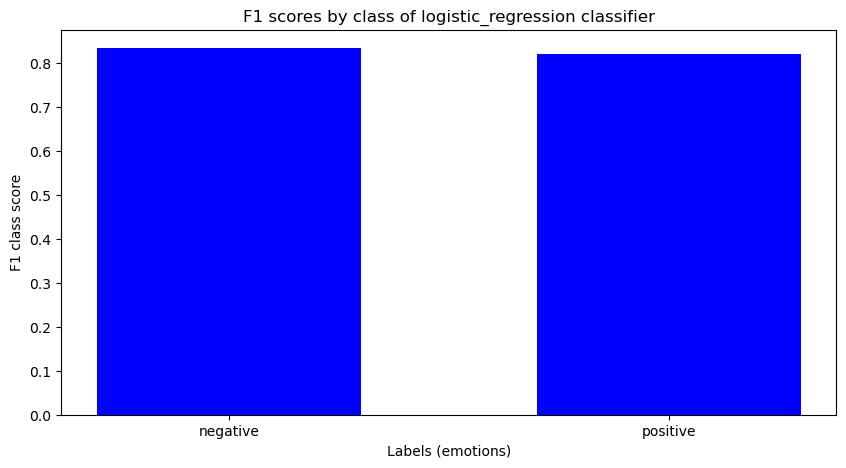

In [31]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions_binary = list(f1_scores_binary.keys())
f1_score_values_binary = list(f1_scores_binary.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions_binary, f1_score_values_binary, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of logistic_regression classifier")
plt.show()

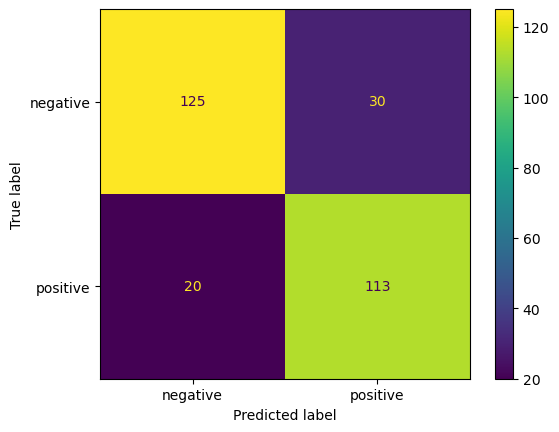

In [32]:
metrics.ConfusionMatrixDisplay.from_predictions(emotions_binary_val, initial_classifier_results_binary["logistic_regression"]["val"]["predictions"])
plt.show()

##### Feature visualisation

In [33]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [34]:
import treelib

def add_node(tree, feature, is_feature):
    feature_parent, delimiter, feature_name = feature.rpartition("_")
    
    if not tree.contains(feature_parent):
        add_node(tree, feature_parent, False)
    
    try:
        tree.create_node(tag=feature_name, identifier=feature, parent=feature_parent, data=is_feature)
    except treelib.exceptions.DuplicatedNodeIdError as error:
        # Such node already exists, potentially because recursive parent creation created it before reaching the node itself
        if is_feature:
            feature_tree.get_node(feature).data = True

feature_tree = treelib.Tree()

feature_tree.create_node(tag="ROOT", identifier="", data=False)

for column in speeches_train.columns:
    add_node(feature_tree, column, True)

In [35]:
# Taken from https://medium.com/dive-into-ml-ai/tree-data-visualization-with-treelib-71633f6fd8fb
import subprocess

feature_tree.to_graphviz("Feature hierarchy graph description.dot")
subprocess.call(["dot", "-Tsvg", "hello.dot", "-o", "Feature hierarchy graph.svg"])

2

In [36]:
# feature_tree.all_nodes()

In [44]:
feature_endings = []
analysis_by_endings = {}

for column in speeches_train.columns:
    feature_parent, delimiter, ending = column.rpartition("_")
    feature_endings.append(ending)
    
    if ending not in analysis_by_endings.keys():
        analysis_by_endings[ending] = {"features": []}
    
    analysis_by_endings[ending]["features"].append(column)
    
print(Counter(feature_endings))

Counter({'range': 130, 'maxPos': 130, 'minPos': 130, 'quartile2': 130, 'quartile3': 130, 'iqr1-2': 130, 'iqr2-3': 130, 'iqr1-3': 130, 'percentile99.0': 130, 'pctlrange0-1': 130, 'stddev': 130, 'skewness': 130, 'kurtosis': 130, 'upleveltime25': 130, 'upleveltime50': 130, 'upleveltime75': 130, 'upleveltime90': 130, 'risetime': 130, 'leftctime': 130, 'lpgain': 130, 'lpc0': 130, 'lpc1': 130, 'lpc2': 130, 'lpc3': 130, 'lpc4': 130, 'flatness': 130, 'rqmean': 130, 'quartile1': 129, 'percentile1.0': 129, 'meanSegLen': 119, 'maxSegLen': 119, 'minSegLen': 119, 'segLenStddev': 119, 'meanPeakDist': 118, 'peakDistStddev': 118, 'peakRangeAbs': 118, 'peakRangeRel': 118, 'peakMeanAbs': 118, 'peakMeanMeanDist': 118, 'peakMeanRel': 118, 'minRangeRel': 118, 'meanRisingSlope': 118, 'stddevRisingSlope': 118, 'meanFallingSlope': 118, 'stddevFallingSlope': 118, 'amean': 71, 'posamean': 71, 'linregc1': 71, 'linregc2': 71, 'linregerrQ': 71, 'qregc1': 71, 'qregc2': 71, 'qregc3': 71, 'qregerrQ': 71, 'centroid': 

#### Feature optimisation section

In [45]:
classifier_for_feature_optimisation = logistic_regression
baseline_f1_score = initial_classifier_results["logistic_regression"]["val"]["F1"]

features_used_for_testing = 10_000 # 50 # 600

# speeches_train_copy = speeches_train.copy()
# speeches_train_copy.drop(speeches_train.columns[features_used_for_testing:], axis=1, inplace=True)
# speeches_val_copy = speeches_val.copy()
# speeches_val_copy.drop(speeches_val.columns[features_used_for_testing:], axis=1, inplace=True)

In [109]:
from ipywidgets import IntProgress

# raise Exception("Prevent this cell from running so that it doesn't get stuck")

endings_progress_bar = IntProgress(
    min=0,
    max=len(analysis_by_endings.keys())-1,
    description = f"0/{len(analysis_by_endings)-1} ending"
)

progress_bar = IntProgress(
    min=0,
    max=len(speeches_train_copy.columns)-1,
    description = f"0th feature"
)

inner_progress_bar = IntProgress(
    min=0,
    max=len(speeches_train.columns)-1,
    description = f"0/{len(speeches_train_copy.columns)-1}"
)

display(endings_progress_bar)
display(progress_bar)
display(inner_progress_bar)

for ending_index, data in enumerate(list(analysis_by_endings.values())[43:]):
    data["final_data_frame"] = pd.DataFrame()
    data["removed_features"] = []

    speeches_train_copy = speeches_train.copy()[data["features"]]
    speeches_val_copy = speeches_val.copy()[data["features"]]
    
    progress_bar.value = 0
    progress_bar.max = len(speeches_train_copy.columns)-1
    inner_progress_bar.value = 0
    inner_progress_bar.max = len(speeches_train_copy.columns)-1
    endings_progress_bar.description = f"{ending_index}/{len(analysis_by_endings)-1} ending"
    
    for feature_index in range(len(speeches_train_copy.columns)-1): # -1 so that the last feature is not deleted and an empty DataFrame is passed
        progress_bar.description = f"{feature_index}/{len(speeches_train_copy.columns)-1} feature"

        # Setting the new baseline
        result = fit_predict_and_score_classifier(
                classifier_for_feature_optimisation,
                speeches_train_copy,
                speeches_val_copy, # speeches_val,
                emotions_train,
                emotions_val,
                set(emotions)
            )
        max_f1_score = result["val"]["F1"]
        column_to_remove = None

        # Finding the worst F1-reducing feature
        inner_progress_bar.max = len(speeches_train_copy.columns)
        inner_progress_bar.value = 0

        for index, column in enumerate(speeches_train_copy.columns):
            inner_progress_bar.description = f"{index}/{len(speeches_train_copy.columns)-1}"

            result = fit_predict_and_score_classifier(
                classifier_for_feature_optimisation,
                speeches_train_copy.drop([column], axis=1),
                speeches_val_copy.drop([column], axis=1), # speeches_val.drop([column], axis=1),
                emotions_train,
                emotions_val,
                set(emotions)
            )
            f1_score = result["val"]["F1"]

            if f1_score > max_f1_score:
                max_f1_score = f1_score
                column_to_remove = column

            inner_progress_bar.value += 1

        # Removing the worst feature
        if column_to_remove is not None:
            speeches_train_copy.drop([column_to_remove], axis=1, inplace=True)
            speeches_val_copy.drop([column_to_remove], axis=1, inplace=True) # speeches_val.drop([column_to_remove], axis=1, inplace=True)
            data["removed_features"].append((column_to_remove, max_f1_score, max_f1_score - f1_score))
            progress_bar.value += 1
        else:
            progress_bar.value = progress_bar.max
            inner_progress_bar.value = inner_progress_bar.max
            data["final_data_frame"] = speeches_train_copy.copy()
            break
            
    endings_progress_bar.value += 1

IntProgress(value=0, description='0/55 ending', max=55)

IntProgress(value=0, description='0th feature', max=0)

IntProgress(value=0, description='0/0', max=6370)

In [110]:
import json

# modified_analysis_by_endings = {k: {"features": v["features"], "final_data_frame": v["final_data_frame"].to_json(), "removed_features": v["removed_features"]} for k,v in analysis_by_endings}

modified_analysis_by_endings = {}

for k,v in analysis_by_endings.items():
#     if "features" in v.keys():
#         modified_analysis_by_endings[k] = v["features"]
#     if "final_data_frame" in v.keys():
#         modified_analysis_by_endings[k] = v["final_data_frame"].to_json()
    if "removed_features" in v.keys():
        modified_analysis_by_endings[k] = v["removed_features"]


# for data in modified_analysis_by_endings.values():
#     print(data)
# #     data["final_data_frame"] = data["final_data_frame"].to_json()

# print(modified_analysis_by_endings.keys())
# print(modified_analysis_by_endings["range"])





In [111]:
with open('result.json', 'w') as fp:
    json.dump(modified_analysis_by_endings, fp)

### ––––––––––––––––––––––––––

In [ ]:
# display(removed_features)

In [ ]:
# display(len(speeches_train_copy.columns))

In [ ]:
# feature_f1_comparison = {"BASELINE": initial_classifier_results["svc"]["val"]["F1"]} | {feature: [feature_result["val"]["F1"]] for feature, feature_result in feature_optimisation_results.items()}

# f1_comparison_data_frame = pd.DataFrame.from_dict(feature_f1_comparison)

# f1_comparison_data_frame.to_csv("F1 scores.csv")

# display(f1_comparison_data_frame)

### ––––––––––––––––––––––––––

In [112]:
all_removed_features = [removed_feature[0] for removed_list in modified_analysis_by_endings.values() for removed_feature in removed_list]
all_removed_parents = [feature.rpartition("_")[0] for feature in all_removed_features]

In [113]:
# Counter(all_removed_parents)

In [115]:
Counter(all_removed_parents).most_common(20)

[('audSpec_Rfilt_sma[22]', 9),
 ('audSpec_Rfilt_sma[11]', 9),
 ('audSpec_Rfilt_sma[7]', 9),
 ('pcm_fftMag_spectralCentroid_sma', 8),
 ('pcm_fftMag_spectralRollOff25.0_sma_de', 7),
 ('audSpec_Rfilt_sma_de[23]', 7),
 ('pcm_fftMag_spectralRollOff75.0_sma_de', 7),
 ('audSpec_Rfilt_sma[16]', 7),
 ('pcm_fftMag_spectralKurtosis_sma_de', 7),
 ('audSpec_Rfilt_sma[14]', 7),
 ('pcm_RMSenergy_sma', 7),
 ('pcm_RMSenergy_sma_de', 7),
 ('pcm_fftMag_psySharpness_sma_de', 7),
 ('audSpec_Rfilt_sma_de[21]', 6),
 ('audSpec_Rfilt_sma_de[15]', 6),
 ('mfcc_sma_de[3]', 6),
 ('mfcc_sma_de[9]', 6),
 ('audspecRasta_lengthL1norm_sma_de', 6),
 ('audSpec_Rfilt_sma_de[24]', 6),
 ('pcm_fftMag_spectralHarmonicity_sma', 6)]